Corpus length: 581888
Total words: 109226
Unique words: 7744
Example of prev_words: ['project', 'gutenberg', 's', 'the', 'adventures']
Example of next_words: of
Starting training on batch 1/9...
Epoch 1/2
75/75 [==============================] - 24s 292ms/step - loss: 6.8986 - accuracy: 0.0436 - val_loss: 6.9310 - val_accuracy: 0.0120
Epoch 2/2
75/75 [==============================] - 23s 299ms/step - loss: 6.4450 - accuracy: 0.0485 - val_loss: 6.8126 - val_accuracy: 0.0280
Training completed for batch 1/9.
Starting training on batch 2/9...
Epoch 1/2
75/75 [==============================] - 23s 312ms/step - loss: 6.4463 - accuracy: 0.0551 - val_loss: 6.6517 - val_accuracy: 0.0400
Epoch 2/2
75/75 [==============================] - 21s 282ms/step - loss: 6.2674 - accuracy: 0.0581 - val_loss: 6.5994 - val_accuracy: 0.0540
Training completed for batch 2/9.
Starting training on batch 3/9...
Epoch 1/2
75/75 [==============================] - 22s 290ms/step - loss: 6.2848 - accuracy: 0.0657 -

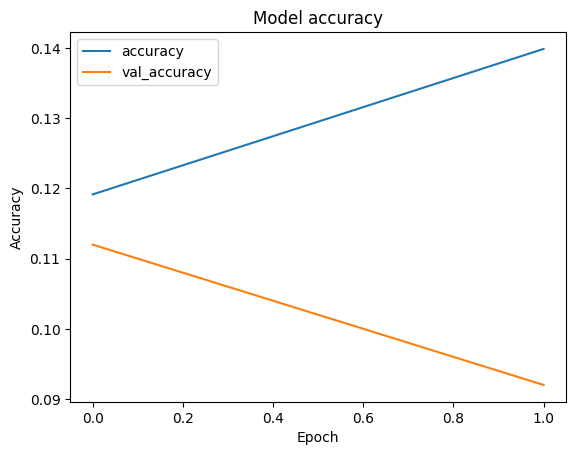

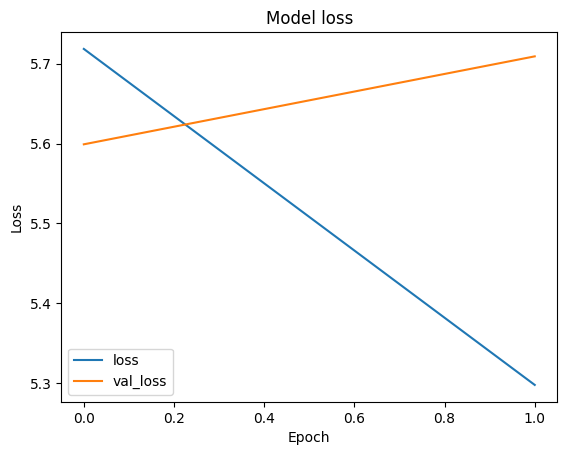

In [2]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Load and preprocess the text
text = open('1661-0.txt', encoding='UTF-8').read().lower()
print('Corpus length:', len(text))

# Tokenize the text
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)
print('Total words:', len(words))

# Use a smaller subset for initial testing
words = words[:100000]  # Adjust this number based on available memory

# Get unique words and create a mapping from word to index
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
print('Unique words:', len(unique_words))

# Prepare the dataset
WORD_LENGTH = 5
prev_words = []
next_words = []

for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])

print('Example of prev_words:', prev_words[0])
print('Example of next_words:', next_words[0])

# Split the data into manageable batches
batch_size = 10000
num_batches = len(prev_words) // batch_size

def vectorize_batch(prev_words_batch, next_words_batch, unique_word_index, WORD_LENGTH, unique_words):
    X = np.zeros((len(prev_words_batch), WORD_LENGTH, len(unique_words)), dtype=bool)
    Y = np.zeros((len(next_words_batch), len(unique_words)), dtype=bool)
    for i, each_words in enumerate(prev_words_batch):
        for j, each_word in enumerate(each_words):
            X[i, j, unique_word_index[each_word]] = 1
        Y[i, unique_word_index[next_words_batch[i]]] = 1
    return X, Y

# Build the model
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

# Compile the model
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model on each batch
for batch_num in range(num_batches):
    start = batch_num * batch_size
    end = start + batch_size
    prev_words_batch = prev_words[start:end]
    next_words_batch = next_words[start:end]
    X_batch, Y_batch = vectorize_batch(prev_words_batch, next_words_batch, unique_word_index, WORD_LENGTH, unique_words)

    print(f'Starting training on batch {batch_num + 1}/{num_batches}...')
    history = model.fit(X_batch, Y_batch, validation_split=0.05, batch_size=128, epochs=2, shuffle=True, verbose=1).history
    print(f'Training completed for batch {batch_num + 1}/{num_batches}.')

# Plotting the training and validation accuracy and loss from the last batch
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [3]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("How are you ".lower())

how
are
you


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [5]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [6]:
def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]

# RESULT

In [7]:
q =  "Do your work by your own instead of depending on someone"
print("correct sentence: ",q)
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence: ",seq)
print("next possible words: ", predict_completions(seq, 5))

correct sentence:  Do your work by your own instead of depending on someone
Sequence:  do your work by your
do
your
work
by
your
next possible words:  ['wife', 'friend', 'own', 'right', 'very']


THANK YOU